<font color=gray>Oracle Cloud Infrastructure Data Science Demo Notebook

Copyright (c) 2021 Oracle, Inc. <br>
Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl.
</font>

# Model Deployment -- Getting Started Guide

In this simple example we are going to deploy an `sklearn` random forest classifer as an HTTP endpoint using Model Deployment. 

## Training a model in a Notebook Session and Saving it to the Model Catalog 

To get started I train a simple binary classifier using `scikit-learn`.  The business problem it itself and the quality of the model do not really matter in this case and the model is only used for illustrative purposes. In fact any binary classifier would do just fine. 

I used the `sklearn` `make_classification()` function to create a balanced synthetic binary classification dataset and I am going to use it to train a random forest classifier. The model takes in eight numerical features labelled `feat1`,...,`feat8`. 

You can do the same by launching a notebook session in Oracle Cloud Infrastructure Data Science service and execute the following cell in your notebook. I am using [resource principals](https://blogs.oracle.com/datascience/resource-principals-data-science-service) to authenticate to the model catalog, object storage, and Model Deployment. I recommend going over the `getting-started.ipynb` notebook yourself to get your session set up with resource principals. 

In [ ]:
!pip install --upgrade oci

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import numpy as np 
import pandas as pd 
import ads 
import json 

# Using resource principal to authenticate when using the model catalog. By default, ADS 
# uses the config+key flow to authenticate against the model catalog. Remove this line 
# if you want to use the config+key authn method. 
ads.set_auth(auth='resource_principal') 

# Here we create a simple (balanced) binary classfication dataset with 8 features, 
# and a sample of 10K rows. 
X, y = make_classification(n_samples=10000, n_features=8, n_informative=4,
                           random_state=0, shuffle=True)

# convert to a pandas dataframe for easy manipulations: 
train = pd.DataFrame(X, columns=['feat1', 'feat2', 'feat3', 'feat4', 
                                 'feat5', 'feat6', 'feat7', 'feat8'])
target = pd.Series(y)

In [ ]:
# training the random forest classifier from scikit-learn: 
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train, target)

Next we are going to create a model artifact. First step is to specify a local folder where the artifact is prepared: 

In [ ]:
from ads.common.model_artifact import ModelArtifact
from ads.common.model_export_util import prepare_generic_model
import os

#Replace with your own path: 
path_to_rf_artifact = f"./md-test-artifact"
if not os.path.exists(path_to_rf_artifact):
    os.mkdir(path_to_rf_artifact)

I use ADS `prepare_generic_model()` to create all the necessary templatized files that are part of the model artifact. You still need to modify `score.py` to fit your particular use case. Note that all the files in the target artifact directory will be compressed and shipped to the model catalog as your model artifact. 

I decided not to include the artifact files necessary for deployment to Oracle Functions (`function_artifacts=False`). We do not need those files for Model Deployment. The only files needed are `score.py`, `runtime.yaml`, and, of course, the serialized model object. 

In addition, we set the parameter `data_science_env` to `True`. The `data_science_env` parameter when set to `True` instructs ADS to identify if the currently running conda environment is a data science conda environment. If this is the case, ADS assigns values to `INFERENCE_CONDA_ENV` in `runtime.yaml` corresponding to the data science conda environment. Model deployment will pull a copy of the data science conda environment from our service tenancy and install it in each VM instance hosting the model server.
This ensure that the third-party dependencies that your model needs (e.g. sklearn, pandas, etc) are the same as the ones you used with this notebook. This is only applicable to the case where you have used a data science conda environment without installing or modifying the libraries in the environment.

If you installed additional libraries in a data science conda environment or created your own conda environment for training or inference purposes, you **need to first publish the conda to your object object bucket and provide a reference to that published environment by setting the parameter  `INFERENCE_CONDA_ENV` in runtime.yaml to the path on object storage where you put your published conda environment.** The path is available in the Environment Explorer under the "Published Conda Environments" tab in the screenshot below.

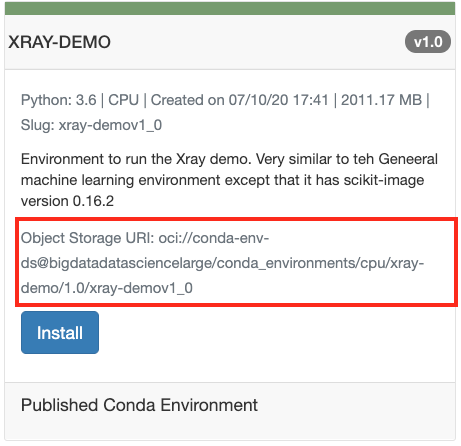

**NOTE**: You can publish an environment by first initializing `odsc conda` with the namespace of your tenancy and the object storage bucket name where you want to store the conda environment. Then execute the `odsc conda publish` command in the terminal to copy the environment in the bucket. This command can take a few minutes to complete:

```
!odsc conda init -b <your-bucket-name>  -n <your-tenancy-namespace> # replace with your values. 
!odsc conda publish -s <env-slug> # use the slug name of the environment you want to publish. 
```

Also make sure that you write a policy allowing model deployment to read objects in your bucket: 

```
Allow any-user to read objects in compartment <your-compartment-name>
where ALL { request.principal.type='datasciencemodeldeployment', 
target.bucket.name=<your-bucket-name> }
```

In [ ]:
#using a data science conda environment for inference purposes? 
using_data_science_conda = True 

if using_data_science_conda: 
    artifact = prepare_generic_model(path_to_rf_artifact, function_artifacts=False, force_overwrite=True, data_science_env=True)
else: 
    # if not, specify the path to your published conda environment on object storage that you want to use for model deployment: 
    # oci://<bucket-name>@<namespace>/<prefix>/<conda-env-name>
    my_published_conda = '<path-to-your-published-conda-environment>'
    artifact = prepare_generic_model(path_to_rf_artifact, function_artifacts=False, force_overwrite=True, inference_conda_env=my_published_conda)

I first need to serialize my random forest classifier and save it to disk. I use `joblib` to save my model to disk which is the preferred way for [scikit-learn models](https://scikit-learn.org/stable/modules/model_persistence.html). 

In [ ]:
from joblib import dump

dump(clf, os.path.join(path_to_rf_artifact, "rf.joblib"))

In [ ]:
%%writefile {path_to_rf_artifact}/score.py

import json
import os
from joblib import load
import pandas as pd
import io
import logging 

# logging configuration - OPTIONAL 
logging.basicConfig(format='%(name)s - %(levelname)s - %(message)s', level=logging.INFO)
logger_pred = logging.getLogger('model-prediction')
logger_pred.setLevel(logging.INFO)
logger_feat = logging.getLogger('input-features')
logger_feat.setLevel(logging.INFO)

"""
   Inference script. This script is used for prediction by scoring server when schema is known.
"""


def load_model():
    """
    Loads model from the serialized format

    Returns
    -------
    model:  a model instance on which predict API can be invoked
    """
    model_dir = os.path.dirname(os.path.realpath(__file__))
    contents = os.listdir(model_dir)
    model_file_name = "rf.joblib"
    # TODO: Load the model from the model_dir using the appropriate loader
    # Below is a sample code to load a model file using `cloudpickle` which was serialized using `cloudpickle`
    # from cloudpickle import cloudpickle
    if model_file_name in contents:
        with open(os.path.join(os.path.dirname(os.path.realpath(__file__)), model_file_name), "rb") as file:
            model = load(file) # Use the loader corresponding to your model file.
    else:
        raise Exception('{0} is not found in model directory {1}'.format(model_file_name, model_dir))
    
    return model


def predict(data, model=load_model()) -> dict:
    """
    Returns prediction given the model and data to predict

    Parameters
    ----------
    model: Model instance returned by load_model API
    data: Data format as expected by the predict API of the core estimator. For eg. in case of sckit models it could be numpy array/List of list/Panda DataFrame

    Returns
    -------
    predictions: Output from scoring server
        Format: { 'prediction': output from `model.predict` method }

    """
    assert model is not None, "Model is not loaded"
    X = pd.read_json(io.StringIO(data)) if isinstance(data, str) else pd.DataFrame.from_dict(data)
    preds = model.predict(X).tolist()
    # to logging service: 
    logger_pred.info(preds)
    logger_feat.info(X)
    return { 'prediction': preds }

### Testing the Model Artifact before Saving to the Model Catalog 

In [ ]:
input_data = train[:5].to_json()

In [ ]:
# add the path of score.py: 
import sys 
sys.path.insert(0, path_to_rf_artifact)

from score import load_model, predict

# Load the model to memory 
_ = load_model()

# make predictions on the training dataset: 
predictions_test = predict(input_data, _)

# comparing the predictions from predict() to the predictions array I created above. 
#print(f"The two arrays are equal: {np.array_equal(predictions_test['prediction'], predictions)}")

In [ ]:
predictions_test

In [ ]:
# Capturing a sample payload file for testing the Function in production: 

with open(os.path.join(path_to_rf_artifact, "sample-payload.json"),'w') as f:
    json.dump(input_data,f)

In [ ]:
# Saving the model artifact to the model catalog. 

catalog_entry = artifact.save(display_name='sklearn-rf-2', 
              description='A model to test model deployment')

In [ ]:
catalog_entry.id

# Deploying the Model 

Through the console or programmatically through the OCI Python SDK: 

In [ ]:
import oci 
from oci.data_science import DataScienceClient, DataScienceClientCompositeOperations

from oci.data_science.models import ModelConfigurationDetails, InstanceConfiguration, \
                                    FixedSizeScalingPolicy, CategoryLogDetails, LogDetails, \
                                    SingleModelDeploymentConfigurationDetails, CreateModelDeploymentDetails

A couple of ways to authenticate against model deployment. First one is through resource principals. Second one is to use the config + pem files in your notebook session. Pick the one that you want to use. 

In [ ]:
# using resource principals
auth = oci.auth.signers.get_resource_principals_signer()
data_science = DataScienceClient({}, signer=auth)

# OR the config + pem authn flow: 
#oci_config = oci.config.from_file('~/.oci/config', "DEFAULT")
#data_science = DataScienceClient(oci_config)

The cell below provides the necessary parameters for a model deployment. The first three parameters are standard to all the Data Science resources:   

In [ ]:
# Configuration of the model: 
# We deploy the sklearn model we saved to the model catalog in this notebook (catalog_entry.id)
# You can change the shape, instance_count, or the bandwidth of the load balancer (in Mbps)
model_configuration_details_object = ModelConfigurationDetails(model_id=catalog_entry.id,
                                                               instance_configuration=InstanceConfiguration(instance_shape_name='VM.Standard2.1'),
                                                               scaling_policy=FixedSizeScalingPolicy(instance_count=1),
                                                               bandwidth_mbps=20)

# Single Model Deployment Configuration
# Includes info about the deployment type and the model configuration details: 
# At the moment, only deployment+type='SINGLE_MODEL' is supported. 
single_model_config = SingleModelDeploymentConfigurationDetails(deployment_type='SINGLE_MODEL',
                                                                model_configuration_details=model_configuration_details_object)


# OPTIONAL - Configuration of the access and predict logs. 
# Make sure you have the proper policy in place to allow model deployment to emit predict/access logs. For example: 
# allow any-user to use log-content in tenancy where ALL {request.principal.type = 'datasciencemodeldeployment'}
logging_config = False
if logging_config: 

    access_log_group_id = "<your-log-group-id>"
    access_log_id = "<your-log-id>"
    predict_log_group_id = "<your-log-group-id>"
    predict_log_id = "<your-log-id>"

    logs_configuration_details_object = CategoryLogDetails(access=LogDetails(log_group_id=access_log_group_id,
                                                                             log_id=access_log_id),
                                                           predict=LogDetails(log_group_id=predict_log_group_id,
                                                                             log_id=predict_log_id))
else: 
    logs_configuration_details_object = {}


# Wrapping all of these configs into a model deploy configuration: 
# Replace with your own values for display_name, description, project, and compartment OCIDs 
model_deploy_configuration = CreateModelDeploymentDetails(display_name='screencast-deployment-1',
                                                          description='simple-description',
                                                          project_id=os.environ['PROJECT_OCID'],
                                                          compartment_id=os.environ['NB_SESSION_COMPARTMENT_OCID'],
                                                          model_deployment_configuration_details=single_model_config,
                                                          category_log_details=logs_configuration_details_object)

In [ ]:
# Creating a model deployment. This action takes a few minutes

data_science_composite = DataScienceClientCompositeOperations(data_science)
model_deployment = data_science_composite.create_model_deployment_and_wait_for_state(model_deploy_configuration, 
                                                                                     wait_for_states=["SUCCEEDED", "FAILED"])

# Invoking the Model 

Last step is to invoke/call the model endpoint. Here again you can pick between resource principals or the config+key authn flow. 

In [ ]:
import requests
import oci
from oci.signer import Signer

Before you can execute the cell below, copy and paste the URI of your model deployment. You can find that value in the OCI console under the detail page of your model deployment. In the **Resources** menu of the detail page, click on **"Invoking Your Model"**. You will find the HTTP endpoint of the model. 

In [ ]:
# model deployment endpoint. Here we assume that the notebook region is the same as the region where the model deployment occurs.
# Alternatively you can also go in the details page of your model deployment in the OCI console. Under "Invoke Your Model", you will find the HTTP endpoint 
# of your model. 
uri = f"<replace-with-your-model-deployment-uri"
print(uri)

From a notebook session, you have two options to authenticate to the model deployment `/predict` endpoint: with user principal (config+key) or with resource principal. We are using user principal. If you prefer to use resource principal, set `using_rps=True` : 

In [ ]:
# Using Resource principal to authenticate against the model endpoint. Set using_rps=False if you are using 
# the config+key flow. 
using_rps = True

# payload: 
input_data = train[5:25].to_json()

if using_rps: # using resource principal:     
    auth = oci.auth.signers.get_resource_principals_signer()
else: # using config + key: 
    config = oci.config.from_file("~/.oci/config") # replace with the location of your oci config file
    auth = Signer(
        tenancy=config['tenancy'],
        user=config['user'],
        fingerprint=config['fingerprint'],
        private_key_file_location=config['key_file'],
        pass_phrase=config['pass_phrase'])

In [ ]:
%%time
    
# submit request to model endpoint: 
response = requests.post(uri, json=input_data, auth=auth)

Let's take a look at the status code: 

In [ ]:
assert response.status_code == 200, 'Error'

and the model predictions: 

In [ ]:
print(json.loads(response.content))